# 第8章: ニューラルネット
>第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ

## 70. 単語ベクトルの和による特徴量
>問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい  

>xiは問題60でダウンロードしたやつでおけ.  
今回は「ビジネス」「科学技術」「エンタメ」「健康」の4カテゴリ分類になるので, 0=<yi=<3となる.

In [7]:
# 問題50で構築したデータを確認
!head -3 train.txt

	TITLE	CATEGORY
0	RPT-Fitch Updates EMEA Consumer ABS Rating Criteria & Auto Residual Value  ...	b
1	Gurlitt Wants to Return Nazi-Looted Art, Sueddeutsche Reports	e


In [8]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
# xiを準備
import gensim
# KeyedVecotrsで辞書形式でベクトルを格納, load_word2vec_formatでword2vecのフォーマットでデータを読み込み. バイナリファイルなのでbinary=True
model = gensim.models.KeyedVectors.load_word2vec_format('../work/GoogleNews-vectors-negative300.bin', binary=True)

In [10]:
import pandas as pd
import numpy as np
df_train = pd.read_table('train.txt', sep='\t')[['TITLE', 'CATEGORY']]
df_valid = pd.read_table('valid.txt', sep='\t')[['TITLE', 'CATEGORY']]
df_test = pd.read_table('test.txt', sep='\t')[['TITLE', 'CATEGORY']]
df_train.head()

,TITLE,CATEGORY
0,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,b
1,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",e
2,"UPDATE 1-Fairfax Financial, CEO probed over po...",b
3,Angelina Jolie - Angelina Jolie Will Not Tight...,e
4,Patent Officials Cancel the Washington Redskin...,b


In [11]:
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')   # ストップワードリスト取得
model_words = model.vocab.keys()   #  word2vecにある単語リスト取得

def title_to_vec(row):
    """
    DataFrameの列を入力として, DataFrameに関数を適用する.
    ここではDataFrameのTITLEカラムを入力として, それを単語ベクトル化したものを返す.
    """
    # タイトル文の前処理
    title = re.sub(r'[,.:!\?]', '', row.TITLE)   # カンマとかピリオドとか省く
    tokenized_words = nltk.tokenize.word_tokenize(title)    # トークン化    
    
    # ストップワードと, ダウンロードした単語ベクトルにない単語は除外. model[word]は300次元ベクトル
    title_vecs = [model[word.lower()] for word in tokenized_words if word.lower() in model_words and word.lower() not in stop_words]
    
    if len(title_vecs) == 0:
        return np.nan
    return sum(title_vecs)/len(title_vecs)



def category_to_vec(row):
    """
    CATEGORYを対応する数字へと変換
    """
    category2num = {'b':0, 't':1, 'e':2, 'm':3}
    return category2num[row.CATEGORY]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nagasawa_h/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nagasawa_h/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
df_train['xi_vec'] = df_train.apply(title_to_vec, axis=1)
df_train['yi_vec'] = df_train.apply(category_to_vec, axis=1)

# ベクトル化できなかったTITLEの列は削除
df_train = df_train.dropna()

# 出力例確認
df_train.head()

,TITLE,CATEGORY,xi_vec,yi_vec
0,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,b,"[0.01720581, 0.032263182, 0.021276856, 0.14004...",0
1,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",e,"[0.05343628, 0.06964111, -0.05696869, 0.008666...",2
2,"UPDATE 1-Fairfax Financial, CEO probed over po...",b,"[-0.079241075, -0.017857144, -0.07739258, -0.1...",0
3,Angelina Jolie - Angelina Jolie Will Not Tight...,e,"[-0.08021715, 0.031304255, -0.02086046, 0.1278...",2
4,Patent Officials Cancel the Washington Redskin...,b,"[-0.072021484, 0.06953939, 0.20385742, 0.23103...",0


In [13]:
# test, validDataFrameにも適用
df_test['xi_vec'], df_test['yi_vec'] = df_test.apply(title_to_vec, axis=1), df_test.apply(category_to_vec, axis=1)
df_valid['xi_vec'], df_valid['yi_vec'] = df_valid.apply(title_to_vec, axis=1), df_valid.apply(category_to_vec, axis=1)
df_test, df_valid = df_test.dropna(), df_valid.dropna()



# ファイルへの書き出し
df_train.to_csv('vectorized_train.csv')
df_valid.to_csv('vectorized_valid.csv')
df_test.to_csv('vectorized_test.csv')

## 71. 単層ニューラルネットワークによる予測
>問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ.  
ŷ 1=softmax(x_1W),Ŷ =softmax(X_[1:4]W)

**自分で実装**

In [14]:
def softmax(x):
    """
    ソフトマックス関数.ベクトルを受け取り, ベクトルを返す.
    入力が負の値の時でも0~1に変換できるように, expとる.(しかも微分もしやすい→逆伝播)
    オーバーフローしないように最大値を各要素から引いておく
    """
    x -= np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

class SingleLayerNet:
    
    def __init__(self, input_size=300, output_size=4):
        # 重みの初期化
        np.random.seed(42)
        self.W = np.random.randn(input_size, output_size)   # 正規分布の乱数生成
        
    def predict_y(self, X):   # indexは引数指定できるようにしておくと綺麗 or 入力前に入力値の形を整えておくと良い
        self.x = X[0]
        return softmax(np.dot(self.x, self.W))
    
    def predict_Y(self, X):
        self.X = X[:4]
            
        return [softmax(np.dot(X, self.W)) for X in self.X]

In [15]:
from pprint import pprint
# xi, yiベクトルの取り出し

xi_vec_train = np.array(df_train.xi_vec.tolist())   # 1回Seriesをリストに変換してから, ndarrayにしないと次元が保持されない((4, )->(4, 300)という感じに変換している)
yi_vec_train = np.array(df_train.yi_vec.tolist())

SN = SingleLayerNet()
predict_yi = SN.predict_y(xi_vec_train)
predict_Y = SN.predict_Y(xi_vec_train)
print(predict_yi)
pprint(predict_Y)

[0.01832187 0.0956596  0.86424158 0.02177695]
[array([0.01832187, 0.0956596 , 0.86424158, 0.02177695]),
 array([0.03111409, 0.00743297, 0.95459776, 0.00685517]),
 array([0.01049771, 0.02036487, 0.96048677, 0.00865065]),
 array([0.62431351, 0.0595027 , 0.17839147, 0.13779231])]


In [16]:
print(df_train.xi_vec)

0        [0.01720581, 0.032263182, 0.021276856, 0.14004...
1        [0.05343628, 0.06964111, -0.05696869, 0.008666...
2        [-0.079241075, -0.017857144, -0.07739258, -0.1...
3        [-0.08021715, 0.031304255, -0.02086046, 0.1278...
4        [-0.072021484, 0.06953939, 0.20385742, 0.23103...
                               ...                        
10667    [-0.097324915, 0.042776924, -0.06622096, 0.069...
10668    [-0.026938302, -0.028651645, -0.0661493, 0.020...
10669    [-0.052730016, 0.14003208, -0.019799368, 0.115...
10670    [-0.0050223214, 0.042027064, 0.041028704, 0.09...
10671    [-0.027701242, 0.088309154, -0.032854352, 0.07...
Name: xi_vec, Length: 10671, dtype: object


**Pytorch使って実装**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# モデル定義時に必要となるものを準備
INPUT_FEATURES=300   # 入力
OUTPUT_FEATURES=4   # 出力
activation = F.softmax

# torch.nn.Moduleクラスのサブクラス化によるモデル定義
class NeuralNetwork_with_Softmax(nn.Module):
    def __init__(self):
        super(NeuralNetwork_with_Softmax, self).__init__()
        self.layer1=nn.Linear(INPUT_FEATURES, OUTPUT_FEATURES, bias=False)   # bias=Falseとすると, バイアス項の加算なし.
        self.activation = F.softmax   # この辺もクラスの内部で定義した方が良い
        
    def forward(self, input_data):
        output = self.activation(self.layer1(input_data), dim=-1)   # dim: softmaxを適用する次元を指定.通常考えるのはテンソルなので指定する必要がある.
        return output
    
# モデルのインスタンス化
net = NeuralNetwork_with_Softmax()
net

NeuralNetwork_with_Softmax(
  (layer1): Linear(in_features=300, out_features=4, bias=False)
)

-memo  
Softmaxのdimについて  
通常考えるのはテンソル.dimの値によってテンソルのどの次元に対してソフトマックスを適用するかが決まる(1階方向?2階方向?みたいな)
ただし, 今回与えてるのはベクトルなので, 1階のテンソルとなる.ベクトルの各値に対してソフトマックスを適用することになるので, dim=-1として指定する.

In [18]:
torch_y1 = net(torch.from_numpy(xi_vec_train[0]))
torch_Y = net(torch.from_numpy(xi_vec_train[:4]))
print(torch_y1)
print(torch_Y)

tensor([0.2573, 0.2482, 0.2467, 0.2478], grad_fn=<SoftmaxBackward>)
tensor([[0.2573, 0.2482, 0.2467, 0.2478],
        [0.2521, 0.2499, 0.2575, 0.2405],
        [0.2409, 0.2511, 0.2684, 0.2396],
        [0.2547, 0.2327, 0.2629, 0.2496]], grad_fn=<SoftmaxBackward>)


## 72. 損失と勾配の計算
>学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．  
なお，ある事例xiに対して損失は次式で計算される．  
li=−log[事例xiがyiに分類される確率]  
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする

シンプルにzを計算するだけのモデルNetを定義  
$$
z = \sum_{i=1}^{n}w_i・x_i + b
$$  
ただし今回はバイアスbなし

In [19]:
INPUT_FEATURES=300   # 入力
OUTPUT_FEATURES=4   # 出力
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(INPUT_FEATURES, OUTPUT_FEATURES, bias=False)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

In [20]:
# ニューラルネットのインスタンス化, 計算
simple_net = Net()

x1 = torch.from_numpy(xi_vec_train[:1])
y1 = torch.from_numpy(yi_vec_train)[:1]    # list[0] -> 1番目の要素,    list[:1] -> 1番目の要素だけを取り出したリスト
estimated_y1 = simple_net(x1)
print(f'estimated_y1 = {estimated_y1}')
print(f'true y1 = {y1}', end='\n\n')

# 損失関数(クロスエントロピー誤差関数)の定義, 計算
criterion = nn.CrossEntropyLoss()   # Softmaxが内部で動いているので, モデルないでやっちゃうと2重になる...
loss = criterion(estimated_y1, y1)
loss.backward()

# 結果の出力
print(f'Cross Entropy Loss = {loss}')
print(f'勾配 = {simple_net.fc1.weight.grad}')

estimated_y1 = tensor([[ 0.0563,  0.0079,  0.0328, -0.0459]], grad_fn=<MmBackward>)
true y1 = tensor([0])

Cross Entropy Loss = 1.3435112237930298
勾配 = tensor([[-0.0127, -0.0238, -0.0157,  ..., -0.0384,  0.0104,  0.0690],
        [ 0.0043,  0.0080,  0.0053,  ...,  0.0129, -0.0035, -0.0232],
        [ 0.0044,  0.0082,  0.0054,  ...,  0.0132, -0.0036, -0.0238],
        [ 0.0041,  0.0076,  0.0050,  ...,  0.0122, -0.0033, -0.0220]])


In [21]:
# 上と同じ処理をX[1:4]でも行う
X1 = torch.from_numpy(xi_vec_train[:4])
Y1 = torch.from_numpy(yi_vec_train)[:4]
estimated_Y1 = simple_net(X1)
print(f'estimated_Y1 = {estimated_Y1}')
print(f'true Y1 = {Y1}', end='\n\n')

loss = criterion(estimated_Y1, Y1)
loss.backward()

print(f'Cross Entropy Loss = {loss}')
print(f'勾配 = {simple_net.fc1.weight.grad}')

estimated_Y1 = tensor([[ 0.0563,  0.0079,  0.0328, -0.0459],
        [ 0.0653,  0.0253,  0.0811,  0.0361],
        [-0.0218, -0.0047, -0.0367, -0.0390],
        [-0.0534,  0.0059,  0.0330, -0.0313]], grad_fn=<MmBackward>)
true Y1 = tensor([0, 2, 0, 2])

Cross Entropy Loss = 1.3564918041229248
勾配 = tensor([[-0.0025, -0.0202, -0.0100,  ..., -0.0789,  0.0045,  0.0971],
        [-0.0016,  0.0151, -0.0031,  ...,  0.0101, -0.0076, -0.0341],
        [ 0.0055, -0.0095,  0.0164,  ...,  0.0597,  0.0101, -0.0303],
        [-0.0014,  0.0146, -0.0033,  ...,  0.0091, -0.0070, -0.0327]])


## 73. 確率的勾配効果法による学習
>確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）

In [22]:
# 最適化手法の指定
import torch.optim as optim
optimizer = optim.SGD(simple_net.parameters(), lr=0.01)


# 学習の準備
epoch_size = 100    # epoch_numとかの方がよく使われてそう... ここでのsizeは違和感...?

# Dataloaderを使ってtrain_x, train_yをまとめて扱う   [[x_vec, y], ...[x_vec, y]]
dataset = torch.utils.data.TensorDataset(torch.from_numpy(xi_vec_train), torch.from_numpy(yi_vec_train))
data_loader = torch.utils.data.DataLoader(dataset, shuffle=True)

    
# 学習
train_loss = list()
for epoch in range(epoch_size):   # エポック数分ループを回す
    running_loss = 0.0
    
    for input_x, label_y in data_loader:
        # パラメータの勾配をリセット
        optimizer.zero_grad()
        
        # 順伝搬
        output = simple_net(input_x)
        loss = criterion(output, label_y)
        
        # 逆伝搬
        loss.backward()
        
        # パラメータ更新
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss.append(running_loss/len(xi_vec_train))

### Dataloaderについて
datasetsからバッチごとに取り出すことを目的に使われる.  
基本的には`torch.utils.data.DataLoader`を使う.  
以下イメージ.  
`dataset = [データ全て]`  
`DataLoader = [[batch1], [batch2], ...[batch_n]]`

# 74. 正解率の計測
>問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ

In [23]:
from sklearn.metrics import accuracy_score

def get_accuracy(x, y):
    return accuracy_score(torch.argmax(net(torch.from_numpy(x)), dim=-1), y)

In [24]:
# testデータとvalidデータの準備
xi_vec_test = np.array(df_test.xi_vec.tolist())
yi_vec_test = np.array(df_test.yi_vec.tolist())
xi_vec_valid = np.array(df_valid.xi_vec.tolist()) 
yi_vec_valid = np.array(df_valid.yi_vec.tolist())


# 実行
print(f'Train: {get_accuracy(xi_vec_train, yi_vec_train)}')
print(f'Valid: {get_accuracy(xi_vec_valid, yi_vec_valid)}')
print(f'Test : {get_accuracy(xi_vec_test, yi_vec_test)}')

Train: 0.2547090244588136
Valid: 0.24437781109445278
Test : 0.2413793103448276


# 75. 損失と正解率のプロット
>問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ

In [25]:
# get_accuracy関数において, ネットワーク引数を追加
def get_accuracy(net, x, y):
    return accuracy_score(torch.argmax(net(torch.from_numpy(x)), dim=-1), y)

In [26]:
# ニューラルネットのインスタンス化
simple_net = Net()

# valid_dataの準備
x_valid = torch.from_numpy(xi_vec_valid)
y_valid = torch.from_numpy(yi_vec_valid)

# 最適化手法の指定
import torch.optim as optim
optimizer = optim.SGD(simple_net.parameters(), lr=0.01)


# 学習の準備
epoch_size = 100
# Dataloaderを使ってtrain_x, train_yをまとめて扱う   [[x_vec, y], ...[x_vec, y]]
dataset = torch.utils.data.TensorDataset(torch.from_numpy(xi_vec_train), torch.from_numpy(yi_vec_train))
data_loader = torch.utils.data.DataLoader(dataset, shuffle=True)

    
# 学習
train_loss = list()
train_acc = list()
valid_loss = list()
valid_acc = list()


for epoch in range(epoch_size):   # エポック数分ループを回す
    running_loss = 0.0
    
    for input_x, label_y in data_loader:
        # パラメータの勾配をリセット
        optimizer.zero_grad()
        
        # 順伝搬
        output = simple_net(input_x)
        loss = criterion(output, label_y)
        
        # 逆伝搬
        loss.backward()
        
        # パラメータ更新
        optimizer.step()
        
        running_loss += loss.item()
     
    # 学習の記録
    train_loss.append(running_loss/len(xi_vec_train))
    train_acc.append(get_accuracy(simple_net, xi_vec_train, yi_vec_train))
    
    # valid, testの時は勾配情報(メモリめちゃ食う)はいらないので, 明示的に勾配情報を使わないことを示す(with no gradを使うべし！)
    
    valid_loss.append(criterion(simple_net(x_valid), y_valid).item())
    valid_acc.append(get_accuracy(simple_net, xi_vec_valid, yi_vec_valid))

In [27]:
print(len(train_loss), len(train_acc), len(valid_loss), len(valid_loss))

100 100 100 100


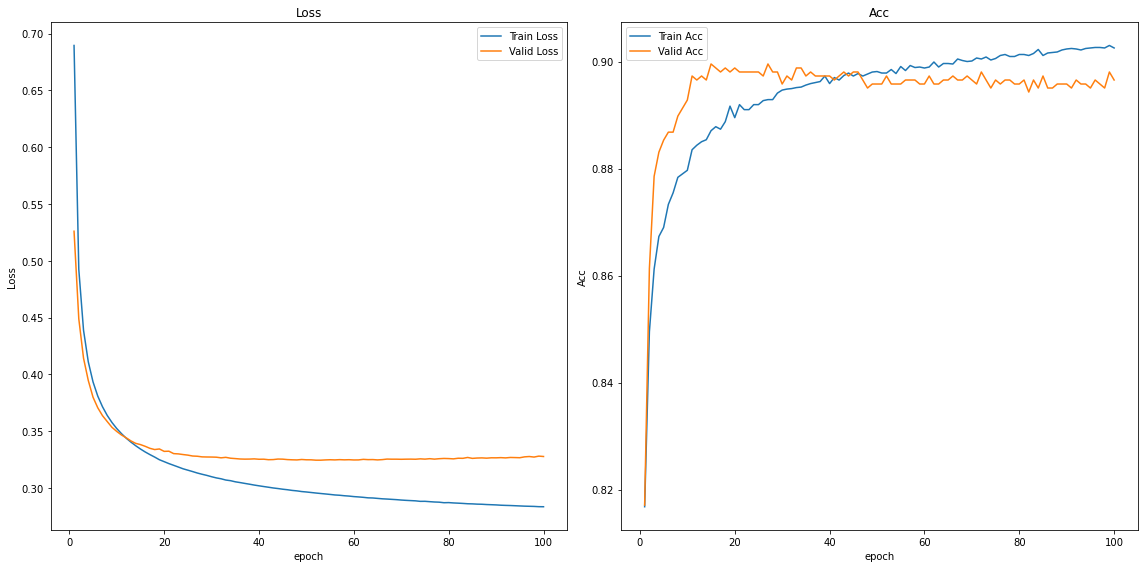

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8))

epoch_ = range(1, 101)
plt.subplot(1,2,1)
plt.plot(epoch_, train_loss, label='Train Loss')
plt.plot(epoch_, valid_loss, label='Valid Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_, train_acc, label='Train Acc')
plt.plot(epoch_, valid_acc, label='Valid Acc')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.title('Acc')
plt.legend()

plt.tight_layout()
plt.show();

# 76. チェックポイント
>問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ  

`net.state_dict(), optimizer.state_dict()`を使うと内部状態取得できる

In [29]:
def save_checkpoint(net, optimizer, epoch):
    # Pytorchのファイルは '.pt' か '.pth' の拡張子を使う
    
    file_name =  'Checkpoints/epoch_' + str(epoch) + '.pt'
    
    # torch.saveを使ってtorch関連の情報をsave
    
    torch.save({
        'epoch': epoch,
        'net_state': net.state_dict(),
        'optim_state': optimizer.state_dict()
    }, file_name)

In [31]:
# ニューラルネットのインスタンス化
simple_net = Net()

# valid_dataの準備
x_valid = torch.from_numpy(xi_vec_valid)
y_valid = torch.from_numpy(yi_vec_valid)

# 最適化手法の指定
import torch.optim as optim
optimizer = optim.SGD(simple_net.parameters(), lr=0.01)


# 学習の準備
epoch_size = 100
# Dataloaderを使ってtrain_x, train_yをまとめて扱う   [[x_vec, y], ...[x_vec, y]]
dataset = torch.utils.data.TensorDataset(torch.from_numpy(xi_vec_train), torch.from_numpy(yi_vec_train))
data_loader = torch.utils.data.DataLoader(dataset, shuffle=True)

    
# 学習


for epoch in range(epoch_size):   # エポック数分ループを回す
    
    for input_x, label_y in data_loader:
        # パラメータの勾配をリセット
        optimizer.zero_grad()
        
        # 順伝搬
        output = simple_net(input_x)
        loss = criterion(output, label_y)
        
        # 逆伝搬
        loss.backward()
        
        # パラメータ更新
        optimizer.step()
        
     
    # 学習の記録
    # save_checkpoint(simple_net, optimizer, epoch)

# 77. ミニバッチ化
>問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ

In [32]:
def batch_trainee(batch_size, epoch_size=100):
    print(f'Batch size: {batch_size}, training started')
    # ニューラルネットのインスタンス化
    simple_net = Net()

    # valid_dataの準備
    x_valid = torch.from_numpy(xi_vec_valid)
    y_valid = torch.from_numpy(yi_vec_valid)

    # 最適化手法の指定
    optimizer = optim.SGD(simple_net.parameters(), lr=0.01)


    # 学習の準備
    # Dataloaderを使ってtrain_x, train_yをまとめて扱う   [[x_vec, y], ...[x_vec, y]]
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(xi_vec_train), torch.from_numpy(yi_vec_train))

    # バッチサイズの指定
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    
    # 学習

    for epoch in range(epoch_size):   # エポック数分ループを回す
    
        for input_x, label_y in data_loader:
            # パラメータの勾配をリセット
            optimizer.zero_grad()
        
            # 順伝搬
            output = simple_net(input_x)
            loss = criterion(output, label_y)
        
            # 逆伝搬
            loss.backward()
        
            # パラメータ更新
            optimizer.step()

In [24]:
%%time
batch_trainee(1)

Batch size: 1, training started
CPU times: user 2min 24s, sys: 324 ms, total: 2min 24s
Wall time: 2min 24s


In [25]:
%%time
batch_trainee(2)

Batch size: 2, training started
CPU times: user 1min 17s, sys: 169 ms, total: 1min 17s
Wall time: 1min 17s


In [26]:
%%time
batch_trainee(4)

Batch size: 4, training started
CPU times: user 42.5 s, sys: 109 ms, total: 42.6 s
Wall time: 42.6 s


In [27]:
%%time
batch_trainee(6)

Batch size: 6, training started
CPU times: user 31.8 s, sys: 140 ms, total: 32 s
Wall time: 32 s


In [28]:
%%time
batch_trainee(8)

Batch size: 8, training started
CPU times: user 25.9 s, sys: 69.8 ms, total: 26 s
Wall time: 26 s


In [29]:
%%time
batch_trainee(10)

Batch size: 10, training started
CPU times: user 22.3 s, sys: 48 ms, total: 22.3 s
Wall time: 22.3 s


# 78. GPU上での学習
>問題77のコードを改変し，GPU上で学習を実行せよ

### GPUを使う場合に必要なこと
GPUを使う場合は, 明示的にGPUに色々渡してあげる必要がある.
GPUに渡すには`.to`メソッドを使う.  
渡すものは2つで,  
1. ネットワーク. `net = net().to(device)`
2. データ. `data.to(device)`  
deviceも指定する必要があるので,`device = torch.device("cudahoge" if torch.cuda.is_available() else 'cpu'`などとする  

研究室のサーバを使うための諸々の設定 ->  
https://scrapbox.io/tohoku-nlp/GPU%E5%88%9D%E6%9C%9F%E8%A8%AD%E5%AE%9ALogs  
(from Rinさん)

In [47]:
import time

INPUT_FEATURES=300   # 入力
OUTPUT_FEATURES=4   # 出力
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(INPUT_FEATURES, OUTPUT_FEATURES, bias=False)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

    def get_accuracy(self, x, y):
        x = torch.from_numpy(x).to(device)
        y = torch.from_numpy(y).to(device)
        return accuracy_score(torch.argmax(self(x), dim=-1).cpu(), y.cpu())

def batch_trainee_gpu(batch_size, epoch_size=100):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    net = Net().to(device)

    # 最適化手法の指定
    creterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(simple_net.parameters(), lr=0.01)


    # 学習の準備
    # trainのデータをdeviceに渡す
    x_train = torch.from_numpy(xi_vec_train).to(device)
    y_train = torch.from_numpy(yi_vec_train).to(device)
    
    dataset = torch.utils.data.TensorDataset(x_train, y_train)

    # バッチサイズの指定
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    
    # 学習
    
    start_time = time.time()

    for epoch in range(epoch_size):   # エポック数分ループを回す
    
        for input_x, label_y in data_loader:
            # パラメータの勾配をリセット
            optimizer.zero_grad()
        
            # 順伝搬
            output = net(input_x)
            loss = criterion(output, label_y)
        
            # 逆伝搬
            loss.backward()
        
            # パラメータ更新
            optimizer.step()
            
    time.sleep(0.01)
    run_time = time.time() - start_time
    print(f'Use device: {device}')
    print(f'Run Time  : {run_time}')
    print(f'Train: {net.get_accuracy(xi_vec_train, yi_vec_train)}')
    print(f'Valid: {net.get_accuracy(xi_vec_valid, yi_vec_valid)}')
    print(f'Test : {net.get_accuracy(xi_vec_test, yi_vec_test)}')

In [48]:
batch_trainee_gpu(100)

Use device: cuda:0
Run Time  : 15.983723402023315
Train: 0.21928591509699186
Valid: 0.22188905547226387
Test : 0.22638680659670166


# 79. 多層ニューラルネットワーク
>問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ

In [50]:
INPUT_FEATURES=300   # 入力
HIDDEN_LAYER1 = 200 # 隠れ層1
HIDDEN_LAYER2 = 100 # 隠れ層2
OUTPUT_FEATURES=4   # 出力

class MLNet(nn.Module):
    def __init__(self):
        super(MLNet, self).__init__()
        self.fc1 = nn.Linear(INPUT_FEATURES, HIDDEN_LAYER1, bias=True)
        self.fc2 = nn.Linear(HIDDEN_LAYER1, HIDDEN_LAYER2, bias=True)
        self.fc3 = nn.Linear(HIDDEN_LAYER2, OUTPUT_FEATURES, bias=True)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def get_accuracy(self, x, y):
        x = torch.from_numpy(x).to(device)
        y = torch.from_numpy(y).to(device)
        return accuracy_score(torch.argmax(self(x), dim=-1).cpu(), y.cpu())

In [54]:
def batch_trainee_gpu_ml(batch_size, epoch_size=100):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    net = MLNet().to(device)

    # 最適化手法の指定
    creterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)


    # 学習の準備
    # trainのデータをdeviceに渡す
    x_train = torch.from_numpy(xi_vec_train).to(device)
    y_train = torch.from_numpy(yi_vec_train).to(device)
    
    dataset = torch.utils.data.TensorDataset(x_train, y_train)

    # バッチサイズの指定
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    
    # 学習
    
    start_time = time.time()

    for epoch in range(epoch_size):   # エポック数分ループを回す
    
        for input_x, label_y in data_loader:
            # パラメータの勾配をリセット
            optimizer.zero_grad()
        
            # 順伝搬
            output = net(input_x)
            loss = criterion(output, label_y)
        
            # 逆伝搬
            loss.backward()
        
            # パラメータ更新
            optimizer.step()
            
    time.sleep(0.01)
    run_time = time.time() - start_time
    print(f'Use device: {device}')
    print(f'Run Time  : {run_time}')
    print(f'Train: {net.get_accuracy(xi_vec_train, yi_vec_train)}')
    print(f'Valid: {net.get_accuracy(xi_vec_valid, yi_vec_valid)}')
    print(f'Test : {net.get_accuracy(xi_vec_test, yi_vec_test)}')

In [55]:
batch_trainee_gpu_ml(100)

Use device: cuda:0
Run Time  : 24.641014099121094
Train: 0.8890450754381033
Valid: 0.8995502248875562
Test : 0.8913043478260869


In [56]:
batch_trainee_gpu_ml(10)

Use device: cuda:0
Run Time  : 190.2666974067688
Train: 0.904788679598913
Valid: 0.8935532233883059
Test : 0.8860569715142429
